In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
from operator import itemgetter
import collections
import itertools
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Network import
import networkx as nx
from community import community_louvain

# Graph Analytics

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Internet_map_1024.jpg/600px-Internet_map_1024.jpg' width="350">

Internet map from The Opte Project, [Wikipedia](https://en.wikipedia.org/wiki/File:Internet_map_1024.jpg)


## Content

The goal of this walkthrough is to provide you with insights on Graph Analytics. After presenting the main concepts, you will be introduced to the techniques to create, visualize, and analyze graphs. Finally, you will practice implementing these techniques.  

This notebook is organized as follows:
- [Background](#Background)
    - [Concepts](#Concepts)
- [Implementation](#Implementation)
    - [Undirected Graph](#Undirected-Graph)
    - [Directed Graph](#Directed-Graph)
    - [Weighted Graph](#Weighted-Graph)
    - [Some helper functions](#Some-helper-functions)
    - [Erdős–Rényi graph](#Erdős–Rényi-graph)
    - [Zachary's Karate Club Network](#Zachary's-Karate-Club-Network)
    - [Diameter and Shortest Paths](#Diameter-and-Shortest-Paths)
    - [Centrality and important nodes](#Centrality-and-important-nodes)
        - [Degree centrality](#Degree-centrality)
        - [Betweenness centrality](#Betweenness-centrality)
        - [PageRank](#PageRank)
    - [Community detection](#Community-detection)
- [Your Turn!](#Your-Turn!)

## Background

[Graphs](https://en.wikipedia.org/wiki/Graph_theory) are mathematical structures used to model pairwise relations between objects. These objects are referred to as vertices (or nodes) and the relationships as edges (or links).

Many social, political, financial, economic interactions occur between different parties/entities. A graph is a abstraction that allows the representation, visualization, and analysis of of interactions between entities.

A [network](https://en.wikipedia.org/wiki/Network_theory) is a graph where the nodes or edges possess attributes. For instance, a typical network might be an edge-weighted graph where the weights refer to costs, lengths or capacities.

Graph analytics and [network theory](https://en.wikipedia.org/wiki/Network_theory) have applications in many fields including:
- electrical and civil engineering,, e.g., to design and to identify weaknesses in power grids, water grids, and transportation networks
- epidemiology, e.g., to analyze the spread of pandemics 
- ecology, e.g., to analyze the nature and strength of interactions between species such as [food-webs](https://en.wikipedia.org/wiki/Food_web)
- biology, e.g., to understand cooperative behaviors. See for instance:
    - Nowak, M. (2006). Five Rules for the Evolution of Cooperation. *Science* 314(5805), DOI: [10.1126/science.1133755](https://www.science.org/doi/full/10.1126/science.1133755)
    - Ohtsuki, H., Hauert, C., Lieberman, E., & Nowak, M. A. (2006). A simple rule for the evolution of cooperation on graphs and social networks. *Nature*, 441(7092), 502-505. DOI: [10.1038/nature04605](https://www.nature.com/articles/nature04605)
- sociology to examine the structure of relationships between social entities, e.g., to understand friendships networks and online behaviors. See for instance:
    - Currarini, S., Jackson, M. O., & Pin, P. (2009). An economic model of friendship: Homophily, minorities, and segregation. *Econometrica*, 77(4), 1003-1045. DOI: [10.3982/ECTA7528](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA7528)
- [economics](https://en.wikipedia.org/wiki/Economics_of_networks), e.g., to analyze trades and markets, relations between firms, or employment and inequalities. See for instance:
    - Calvo-Armengol, A., & Jackson, M. O. (2004). The effects of social networks on employment and inequality. American economic review, 94(3), 426-454. DOI: [10.1257/0002828041464542](https://www.aeaweb.org/articles?id=10.1257/0002828041464542)
- finance, e.g., to study cascades of failures. See for instance:
    - Elliott, M., Golub, B., & Jackson, M. O. (2014). Financial networks and contagion. *American Economic Review*, 104(10), 3115-3153. DOI [10.1257/aer.104.10.3115](https://www.aeaweb.org/articles?id=10.1257/aer.104.10.3115) 
- criminology, e.g., to detect fraud and prevent crime via [link analysis](https://en.wikipedia.org/wiki/Link_analysis) 
- and many more...

### Concepts

Let's define a few important concepts that we will use and illustrate throughout this notebook.

A graph is **connected** when there is a path between every pair of vertices. A [component](https://en.wikipedia.org/wiki/Component_(graph_theory)), also called connected component, is a group of vertices that are connected to each other by paths. In a connected graph, there is one component: the whole graph.  

The [**distance**](https://en.wikipedia.org/wiki/Distance_(graph_theory)) between two vertices in a graph is the number of edges in a shortest path connecting them. It is also called **geodesic** distance or **shortest-path** distance.
- The **diameter** of the graph is the maximum length of the shortest path.
- The [**average shortest path length**](https://en.wikipedia.org/wiki/Average_path_length) is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. Let $V$ be the set of nodes in the graph, $d(s,t)$ shortest path from node $s$ to node $t$, and $n$ the number of nodes, the average shortest path length $a$ is defined as:
$$a=\sum_{s \neq t \in V} \frac{d(s,t)}{n(n-1)}$$

The [**adjacency matrix**](https://en.wikipedia.org/wiki/Adjacency_matrix) is a square matrix used to represent a finite graph, where the elements of the matrix indicate whether pairs of vertices are adjacent (i.e., connected) or not in the graph.

The [**centrality**](https://en.wikipedia.org/wiki/Centrality) of a node indicates its importance in the graph. There are many measures of centrality, including:
- *degree centrality*, defined as the number of links incident upon a node (i.e., the number of ties that a node has).
- [*betweenness centrality*](https://en.wikipedia.org/wiki/Betweenness_centrality), defined as the number of shortest paths that pass through a node. Formally, the betweenness centrality of a node $v$ is $g(v)=\sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$ with $\sigma_{st}$ the total number of shortest paths from node $s$ to $t$ and $\sigma_{st}(v)$ the number of those paths that pass through $v$.
- *closeness centrality*, defined as the average length of the shortest path between the node and all other nodes in the graph. In particular, the *Harmonic centrality* of a node $v$ is: $H(v)=\sum_{u \neq v}\frac{1}{d(u,v)}$
- [*PageRank*](https://en.wikipedia.org/wiki/PageRank) is an algorithm used to measure the importance of each node within the graph. It was invented by Larry Page and Sergey Brin, founders of Google, to help rank webpages in web search. In a nutshell, Pagerank finds the probability that a someone wondering randomly on the graph will end up on or pass from a node. 

## Implementation

We will use the **NetworkX** package ([Documentation](https://networkx.org/)). The package facilitates the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It has a broad range of example networks that we can load with just a function call ([Gallery](https://networkx.github.io/documentation/stable/auto_examples/index.html)).

In addition, we will rely on the `python-louvain` module ([Documentation](https://python-louvain.readthedocs.io/en/latest/)). This module implements community detection. These techniques are useful to detect groups with similar properties.

You can install `networkx` and `python-louvain` in your Conda environment. Alternatively, if you are using Colab, you can use the following line of code:
```python
pip install networkx python-louvain
```

Ok, all set, let's start creating and visualizing graphs!

### Undirected Graph

Let's start by building a simple **undirected graph**, which is a graph where the edges (links) are bidirectional, i.e., with no direction associated with them.

We can use the `Graph` class to create an undirected graph ([Documentation](https://networkx.org/documentation/stable/reference/classes/graph.html#networkx.Graph)). To add nodes and edges we use:
- `add_node()`: add one node
- `add_nodes_from()`: add multiple nodes
- `add_edge()`: add one edge
- `add_edges_from`: add multiple edges

In [2]:
# Create instance of an undirected graph
G = nx.Graph() 

# Add nodes
G.add_node(1)
G.add_nodes_from(range(2,10))  # add multiple nodes at once

# Add edges 
G.add_edge(1,2)
edges = [(2,3), (3,4), (4,5), (5,6), (6,7), (7,8), (8,9), (9,1)]
G.add_edges_from(edges)

print('Our graph has nodes:', G.nodes())
print('The edges are:', G.edges())

Our graph has nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
The edges are: [(1, 2), (1, 9), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]


With `is_directed`, we can check if our graph is directed or not:

In [3]:
print(G.is_directed())

False


In addition, to get a quick overview on the properties of the graph you can use the `info()` method:

In [4]:
print(nx.info(G))

Graph with 9 nodes and 9 edges


The library also has a built-in plotting engine (based on matplotlib), see the [Drawing](https://networkx.org/documentation/stable/reference/drawing) page. 

With `draw_networkx` ([Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx)), you can define options such as the layout with `pos`. By default the graph is based on the "spring" layout. Check the [Graph Layout](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) page for more graph layouts.

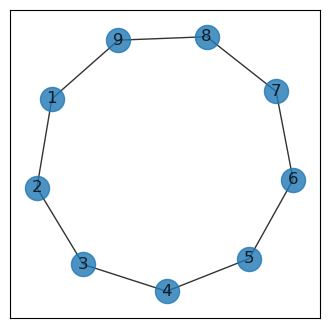

In [5]:
# Draw graph
plt.figure(figsize=(4, 4))
nx.draw_networkx(G, pos = nx.spring_layout(G), with_labels=True,  alpha = 0.8)
plt.show()

We can extract the adjacency matrix of our graph with `adjacency_matrix()` ([Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.graphmatrix.adjacency_matrix.html)).

In [6]:
# Adjacency matrix of the graph
print(nx.adjacency_matrix(G).todense())

[[0 1 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 1 0]]


### Directed Graph

Let's now create a [directed graph](https://en.wikipedia.org/wiki/Directed_graph), i.e., the edges are directed.

We use the `DiGraph` class ([Documentation](https://networkx.org/documentation/stable/reference/classes/digraph.html)).

In [7]:
# Create instance of directed graph
G = nx.DiGraph() 

# Add nodes
G.add_nodes_from(range(1,10)) 

# Add edges 
edges = [(1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,8), (8,9), (9,1)]
G.add_edges_from(edges)

print('Our graph has nodes:', G.nodes())
print('The edges are:', G.edges())
print('The graph is directed:', G.is_directed())
print(nx.info(G))

Our graph has nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
The edges are: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 1)]
The graph is directed: True
DiGraph with 9 nodes and 9 edges


Let's visualize our graph, using the circular layout:

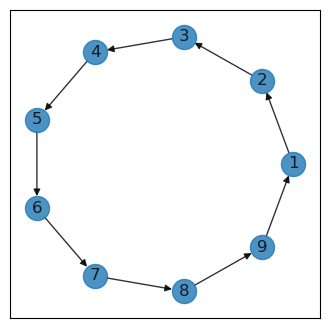

In [8]:
# Draw graph
plt.figure(figsize=(4, 4))
nx.draw_networkx(G, pos = nx.circular_layout(G), with_labels=True,  alpha = 0.8)
plt.show()

### Weighted Graph

Each graph, node, and edge can hold attributes. In such case, our graph is a network. For example, we can define the "weight" of the edges, representing the strength of the link between two nodes.

We can define attributes using attribute dictionaries. Let's use the same graph as before, this time with weights:

Our graph has nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
The edges and weights are: {(1, 2): 0.6, (2, 3): 0.4, (3, 4): 0.3, (4, 5): 0.7, (5, 6): 0.9, (6, 7): 1, (7, 8): 0.2, (8, 9): 0.8, (9, 1): 0.5}
The graph is directed: True


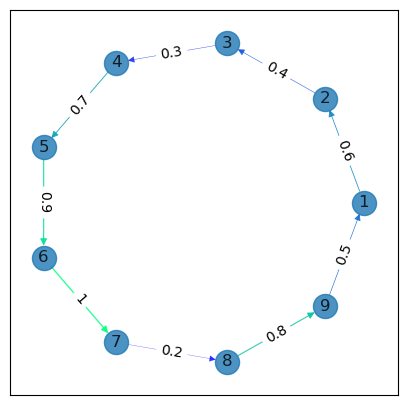

In [9]:
# Create instance of directed graph
G = nx.DiGraph() 

# Add nodes
G.add_nodes_from(range(1,10)) 

# Add edges 
edges = ([(1,2, {"weight":0.6}), 
          (2,3, {"weight":0.4}), 
          (3,4, {"weight":0.3}), 
          (4,5, {"weight":0.7}), 
          (5,6, {"weight":0.9}), 
          (6,7, {"weight":1}),
          (7,8, {"weight":0.2}),
          (8,9, {"weight":0.8}),
          (9,1, {"weight":0.5})])
G.add_edges_from(edges)

# Get edge weights
edge_weights = nx.get_edge_attributes(G, "weight")

print('Our graph has nodes:', G.nodes())
print('The edges and weights are:', edge_weights)
print('The graph is directed:', G.is_directed())

# Draw graph
plt.figure(figsize=(5, 5))
pos = nx.circular_layout(G)
nx.draw_networkx(G, 
                 pos, 
                 with_labels=True,  
                 alpha = 0.8,
                 edge_color = list(edge_weights.values()),     # Edge color
                 edge_cmap = plt.cm.winter,                    # Colormap for mapping intensities of nodes
                 width = list(edge_weights.values()))          # Edge width
nx.draw_networkx_edge_labels(G, pos, edge_weights)          # Add edge weight labels
plt.show()

### Some helper functions

Before continuing our exploration, we define a few helper functions.

The first one prints various graph properties:
- `info()` returns the number of nodes and edges
- `is_connected()` returns `True` if the graph is **connected**, i.e., there is a path between every pair of vertices
- `average_shortest_path_length()` returns the **average shortest path length**.
- `diameter()` returns the **diameter** of the graph, i.e., the maximum length of the shortest path

We'll further explore the notions of diameter and average shortest path length in the section [Diameter and Shortest Paths](#Diameter-and-Shortest-Paths)

In [10]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Average shortest path length are not defined!")

Our second function will draw our graph:

In [11]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o', node_color='g'):
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=node_color, node_shape=node_shape)
    plt.axis('off')
    plt.show()

Our last function will plot the degree distribution of a graph. The **degree** is the number of connected nodes. For directed graphs, in-degree is the number of incoming nodes, while out-degree is the number of outgoing edges. We'll further explore the notion of degree in the section [Degree centrality](#Degree-centrality).

In [12]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots(figsize=(5,3.5))
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

### Erdős–Rényi graph

[Erdős–Rényi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) graph is a random graph model.
named after Hungarian mathematicians [Paul Erdős](https://en.wikipedia.org/wiki/Paul_Erd%C5%91s) and [Alfréd Rényi](https://en.wikipedia.org/wiki/Alfr%C3%A9d_R%C3%A9nyi), who introduced one such graph in 1959.

There are two variants of the Erdős–Rényi random graph model. In our case, the graph is constructed by connecting labeled nodes randomly, with a probability $p$.

With NetworkX, we can build a Erdős–Rényi graph using the function `erdos_renyi_graph()` ([Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph)) of the random [Graph generators](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators).

Graph with 10 nodes and 27 edges
Avg. Shortest Path Length: 1.4222
Diameter: 3.0000


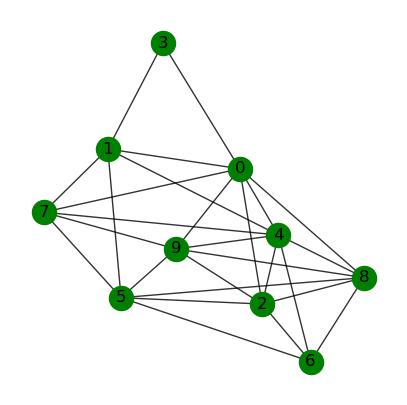

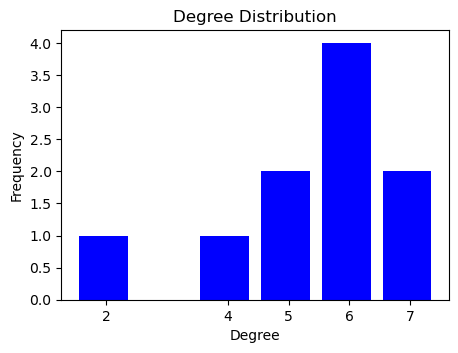

In [13]:
n = 10  # 10 nodes
p = 0.5 # probability of edge creation

# Build Erdős–Rényi graph
erG = nx.random_graphs.erdos_renyi_graph(n=n, p=p)

# Visualize graph properties (using previously-defined function)
describe_graph(erG)
visualize_graph(erG, k=0.05, alpha=0.8)
plot_degree_distribution(erG)

### Zachary's Karate Club Network

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary: 
- The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. 
- During the study, a conflict arose between the administrator and instructor, which led to the split of the club into two. 
- Based on collected data, Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.

Reference: Zachary, W. W. (1977). An information flow model for conflict and fission in small groups. *Journal of anthropological research*, 33(4), 452-473. DOI: [10.1086/jar.33.4.3629752](https://www.journals.uchicago.edu/doi/abs/10.1086/jar.33.4.3629752)

The `karate_club_graph` module of NetworkX ([Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.karate_club_graph.html)) returns a Zachary’s Karate Club graph.

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges
Avg. Shortest Path Length: 2.4082
Diameter: 5.0000


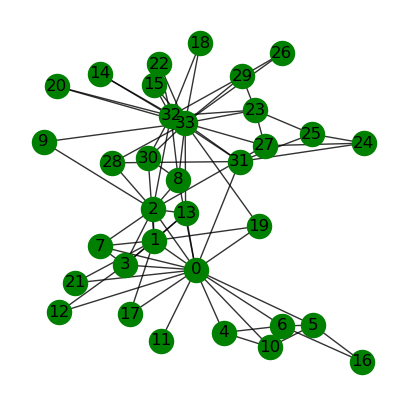

In [14]:
# Build Zachary’s Karate Club graph
karateG = nx.karate_club_graph()

# Visualize graph properties (using previously-defined function)
describe_graph(karateG)
visualize_graph(karateG, k=0.05, alpha=0.8)

Let's draw the same graph with a circular layout:

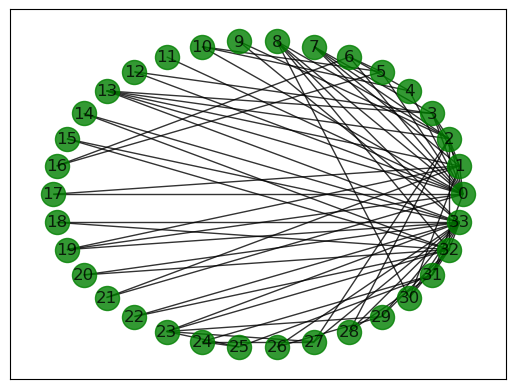

In [15]:
nx.draw_networkx(karateG, pos = nx.circular_layout(karateG), with_labels=True,  node_color='g', alpha = 0.8)

From the above visualization, it is obvious that this graph is connected. We can also check this using the `is_connected()` method, or check the `connected_components()`. Recall that a connected graph has only one component: the whole graph

In [16]:
print('The graph is connected:', nx.is_connected(karateG))
comp = list(nx.connected_components(karateG))
print('The graph contains', len(comp), 'connected component.')

The graph is connected: True
The graph contains 1 connected component.


### Diameter and Shortest Paths

As mentioned in the [Concepts](#Concepts) section, the shortest path ([(geodesic) distance](https://en.wikipedia.org/wiki/Distance_(graph_theory))) between two nodes is the minimum number of edges between them. 

With NetworkX, we can use `shortest_path()` ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html)) to find the shortest path between two nodes, given that they are in the same connected component.

In [17]:
# Shortest path
path_16_30 = nx.shortest_path(karateG, source=16, target=30)
print("Shortest path between nodes 16 and 30:", path_16_30)

Shortest path between nodes 16 and 30: [16, 5, 0, 1, 30]


The **diameter** of the graph is the maximum length of the shortest paths. We use `diameter()` to return the diameter of a graph ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html)).

The [average shortest path length](https://en.wikipedia.org/wiki/Average_path_length) is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. We use `average_shortest_path_length()` to find it ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html)).

In [18]:
# Diameter
print("The diameter of the karate club graph is: ", nx.diameter(karateG))
# Average shortest path in the graph
print("The average shortest path length of the karate club graph is: ", nx.average_shortest_path_length(karateG))

The diameter of the karate club graph is:  5
The average shortest path length of the karate club graph is:  2.408199643493761


### Centrality and important nodes

The [centrality](https://en.wikipedia.org/wiki/Centrality) of a node indicates its importance in the graph. We explore in the following several measures of centrality, namely degree centrality, betweeness centrality, and PageRank.

#### Degree centrality

The *degree centrality* is defined as the number of links incident upon a node (i.e., the number of ties that a node has). Hence, the more interactions a node has, the more important it is! 

We find the degrees of nodes with `degree()` ([Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.degree.html)).

In [19]:
# Dictionary - {node: degree}
degrees = dict(nx.degree(karateG))
# Sort by largest degree
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
# Print 5 nodes with largest degree
for i, deg in sorted_degree[:5]:
    print("Node {} has degree: {}".format(i, deg))

Node 33 has degree: 17
Node 0 has degree: 16
Node 32 has degree: 12
Node 2 has degree: 10
Node 1 has degree: 9


Alternatively, `degree_centrality()` returns the degree centrality of a node as the fraction of nodes it is connected to ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html)).

In [20]:
# Dictionary - {node: degree}
degree_centrality = nx.degree_centrality(karateG)
# Sort by largest degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=itemgetter(1), reverse=True)
# Print 5 nodes with largest degree centrality
for i, deg in sorted_degree_centrality[:5]:
    print("Node {} has degree centrality: {}".format(i, deg))

Node 33 has degree centrality: 0.5151515151515151
Node 0 has degree centrality: 0.48484848484848486
Node 32 has degree centrality: 0.36363636363636365
Node 2 has degree centrality: 0.30303030303030304
Node 1 has degree centrality: 0.2727272727272727


Let's also analyze the *degree distribution* using our previously-defined function. We can see that most of the node have a small degree and there are only a few nodes with a large degree.

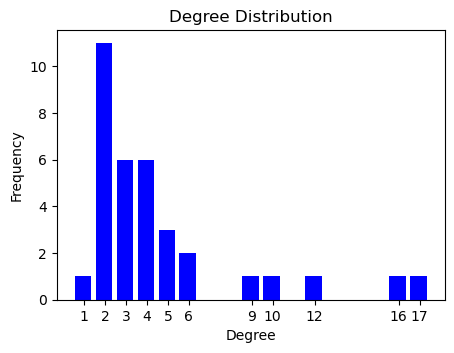

In [21]:
# Plot degree distribution
plot_degree_distribution(karateG)

#### Betweenness centrality

The [*betweenness centrality*](https://en.wikipedia.org/wiki/Betweenness_centrality) is defined as the number of shortest paths that pass through a node. Hence, he more shortest paths pass through a node, the more important it is! Formally, the betweenness centrality of a node $v$ is:
$$g(v)=\sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$
with $\sigma_{st}$ the total number of shortest paths from node $s$ to $t$ and $\sigma_{st}(v)$ the number of those paths that pass through $v$.

We use `betweenness_centrality()` to compute the beetweenness centrality of nodes ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html)).

In [22]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(karateG)
# Sort by largest betweenness centrality
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)
# Print 5 nodes with largest betweenness degree
for i, bw in sorted_betweenness[:5]:
    print("Node {} has betweeness: {}".format(i, bw))

Node 0 has betweeness: 0.43763528138528146
Node 33 has betweeness: 0.30407497594997596
Node 32 has betweeness: 0.145247113997114
Node 2 has betweeness: 0.14365680615680618
Node 31 has betweeness: 0.13827561327561325


We can easily add the betweenness centrality as a new attribute to our nodes, using `set_node_attributes()`:

In [23]:
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(karateG, betweenness, 'betweenness')

Let's visualize the betweeness centrality values for all the nodes in the network. As in the case with degree, there are a *few nodes with very high betweeness centrality*, while most of them have a low value.

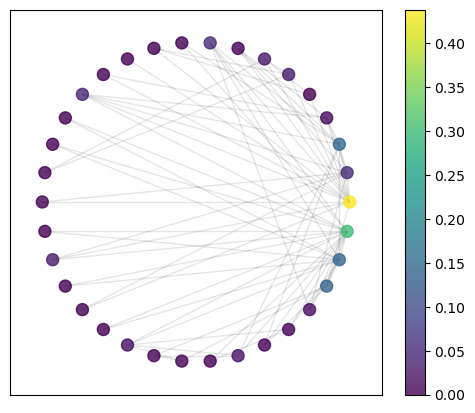

In [24]:
node_bw = list(nx.get_node_attributes(karateG, "betweenness").values())   # List of betweenness values

# Draw graph
plt.figure(figsize=(6, 5))
pos = nx.circular_layout(karateG)        # Graph layout
nc = nx.draw_networkx_nodes(karateG,     ## Plot nodes
                 pos,                    # Layout
                 alpha = 0.8,            # Node transparency
                 node_shape = '.',       # Node shape
                 node_color = node_bw    # Node color
                      )  
ec = nx.draw_networkx_edges(karateG, pos, alpha=0.1)   ## Plot edges
plt.colorbar(nc)                         # Plot colorbar
plt.show()

Note that it is not always the case that the node with the highest degree has also the highest betweenness centrality. For instance, look at the following example:

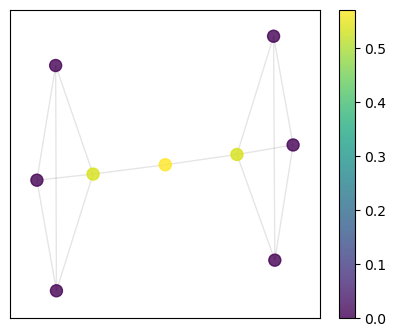

In [25]:
## Define new graph
G = nx.Graph() 
# Add multiple nodes at once
G.add_nodes_from(range(1,10)) 
# Add edges 
edges = [(1,2), (2,3), (3,4), (4,1), (1,3), (2,4), (6,7),
        (4,9), (9,5),
        (5,6), (6,7), (7,8), (8,5), (5,7), (6,8)]
G.add_edges_from(edges)
G.nodes()

## Compute betweenness and set as node attribute
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')
node_G_bw = list(nx.get_node_attributes(G, "betweenness").values()) 

## Draw graph
plt.figure(figsize=(5, 4))
pos = nx.spring_layout(G)            # Graph layout
nc = nx.draw_networkx_nodes(G,           ## Plot nodes
                 pos,                    # Layout
                 alpha = 0.8,            # Node transparency
                 node_shape = '.',       # Node shape
                 node_color = node_G_bw    # Node color
                      )  
ec = nx.draw_networkx_edges(G, pos, alpha=0.1)   ## Plot edges
plt.colorbar(nc)                         # Plot colorbar
plt.show()

The node with the **lowest degree** is the one with the **highest betweeness centrality**. 


#### PageRank

[*PageRank*](https://en.wikipedia.org/wiki/PageRank) is an algorithm used to measure the importance of each node within the graph. It was invented by Larry Page and Sergey Brin, founders of Google, to help rank webpages in web search. In a nutshell, Pagerank finds the probability that a someone wondering randomly on the graph will end up on or pass from a node. 

We can use `pagerank()` to compute page ranks of the nodes in a graph ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank)).

In [26]:
# Compute PageRank
pagerank = nx.pagerank(karateG, alpha=0.8)
# Sort by largest PageRank
sorted_pagerank = sorted(pagerank.items(), key=itemgetter(1), reverse=True)
# Print 5 nodes with largest PageRank
for i, bw in sorted_pagerank[:5]:
    print("Node {} has PageRank: {}".format(i, bw))

Node 33 has PageRank: 0.09486047671556612
Node 0 has PageRank: 0.08681447719172829
Node 32 has PageRank: 0.07407774615757656
Node 2 has PageRank: 0.06022609788477227
Node 1 has PageRank: 0.05576990180502326


Let's compare the betweenness centrality and PageRank results:

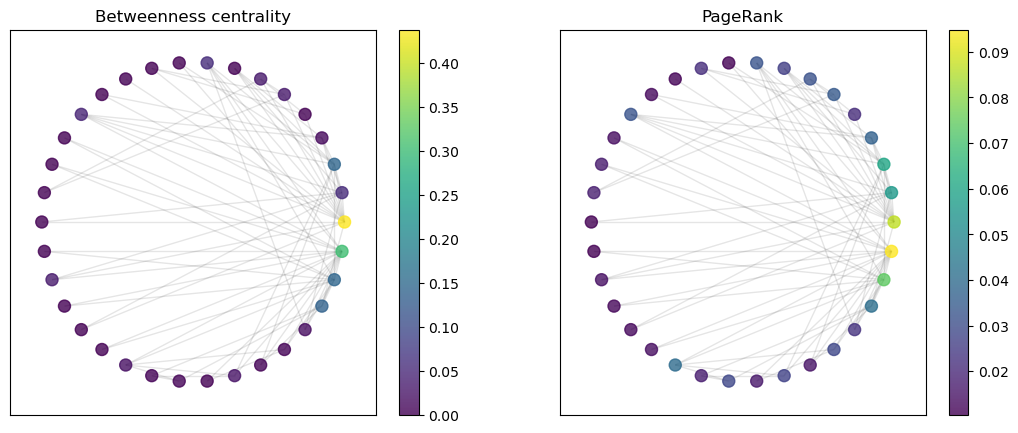

In [27]:
# Draw graphs
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
pos = nx.circular_layout(karateG)        # Graph layout

# Betweenness Centrality
ax[0].set_title("Betweenness centrality")
nc = nx.draw_networkx_nodes(karateG,     ## Plot nodes
                 pos,                    # Layout
                 alpha = 0.8,            # Node transparency
                 node_shape = '.',       # Node shape
                 node_color = node_bw,   # Node color
                 ax=ax[0]
                      )  
ec = nx.draw_networkx_edges(karateG, pos, alpha=0.1, ax=ax[0])   ## Plot edges
plt.colorbar(nc, ax=ax[0])                         # Plot colorbar

# PageRank
ax[1].set_title("PageRank")
nx.set_node_attributes(karateG, pagerank, 'pagerank')     # Add pagerank as node attribute
node_pr = list(nx.get_node_attributes(karateG, 'pagerank').values())    # List of pagerank values
nc1 = nx.draw_networkx_nodes(karateG,     ## Plot nodes
                 pos,                    # Layout
                 alpha = 0.8,            # Node transparency
                 node_shape = '.',       # Node shape
                 node_color = node_pr,   # Node color
                 ax=ax[1]
                      )  
ec1 = nx.draw_networkx_edges(karateG, pos, alpha=0.1, ax=ax[1])   ## Plot edges
plt.colorbar(nc1, ax=ax[1])                         # Plot colorbar

plt.show()

What do you observe?

### Community detection

Community detection is a common class of methods to partition the graph into several clusters. The detected communities can help us understand hidden relationship among different groups of nodes in a network. In this tutorial we use the [Louvain method](https://en.wikipedia.org/wiki/Louvain_Modularity), which is a 
clustering algorithm. The algorithm works in 2 steps:
1. Every node is assigned to be in its own community. 
2. The communities are traversed, and, for each community, it is tested whether by joining it to a neighboring community, we can obtain a better clustering.

For more information, you can read:
- [Community Detection Algorithms](https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae), by Thamindu Dilshan Jayawickrama, published in Towards Data Science
- Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. *Journal of statistical mechanics: theory and experiment, 2008*(10), P10008. DOI [10.1088/1742-5468/2008/10/P10008](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta)

Ok, let's try it! To compute the best partition, we rely on the function `best_partition()` of the the `python-louvain` module ([Documentation](https://python-louvain.readthedocs.io/en/latest/)). The "resolution" is a parameter controlling the size of communities: if greater than 1 then the algorithm favors larger communities.

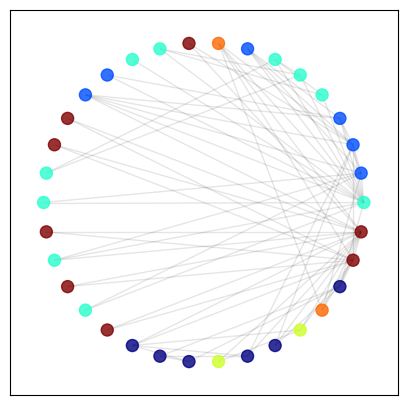

In [28]:
# Compute best partitions
partition = community_louvain.best_partition(karateG, resolution=2)

# Add community as node attribute
nx.set_node_attributes(karateG, partition, 'louvain') 

# Draw graph
plt.figure(figsize=(5, 5))
pos = nx.circular_layout(karateG)        # Graph layout
nx.draw_networkx_nodes(karateG,     ## Plot nodes
                 pos,                    # Layout
                 alpha = 0.8,            # Node transparency
                 node_shape = '.',       # Node shape
                 node_color = list(partition.values()),   # Node color
                 cmap=plt.cm.jet         # Colormap
                      )  
nx.draw_networkx_edges(karateG, pos, alpha=0.1)   ## Plot edges
plt.show()

We can check if the detected communities are consistent with the clubs each node belongs to. In the Zachary's Karate Club, each node has an attribute "club" that indicates the name of the club to which the member represented by that node belongs: either "Mr. Hi" (pseudonym of the instructor of the initial club) or "Officer":

In [29]:
print("Community 0: ")
l0 = [karateG.nodes[i]["club"] for i in karateG.nodes if karateG.nodes[i]["louvain"]==0]
print(" - ".join(l0))
print("Community 1: ")
l1 = [karateG.nodes[i]["club"] for i in karateG.nodes if karateG.nodes[i]["louvain"]==1]
print(" - ".join(l1))

Community 0: 
Officer - Officer - Officer - Officer - Officer - Officer
Community 1: 
Mr. Hi - Mr. Hi - Mr. Hi - Mr. Hi - Mr. Hi - Mr. Hi


## Your Turn!

We want to build a graph from the following adjacency matrix. 

- Before converting the matrix to a networkx graph, can you say whether this adjacency matrix belong to a directed or undirected graph?

In [30]:
adj_mat = np.array([[0, 0, 1, 1, 1, 0, 1, 0, 1, 1],
                    [0, 0, 1, 1, 1, 1, 0, 1, 1, 0],
                    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
                    [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

- Build the networkx graph from the above matrix and check if you answer to the above question is correct.

*Hint:* You can use `nx.from_numpy_array()` ([Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html#from-numpy-array)) to convert a numpy array into a graph.

In [31]:
# YOUR CODE HERE



The **clustering coefficient** is another feature that characterizes the structure and position of a node in a graph. This coefficient measures how connected the neighbors of a node are.

- Compute the clustering coefficient for nodes 4 and 6

*Hint:* You can use `nx.clustering()` ([Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html)) to compute the clustering coefficient.

In [32]:
# YOUR CODE HERE



For unweighted graph, the clustering coefficient of a node $u$ is the fraction of possible triangles through that node that exist:
$$ c_{v} = \frac{2 T(u)}{deg(u)(deg(u)-1)} $$
where $T(u)$ is the number of triangles through node $u$ and $deg(u)$ is the degree of $u$. A triangle is a [cycle graph](https://en.wikipedia.org/wiki/Cycle_graph) with 3 nodes, i.e., 3 nodes that are connected to each others. 

- Draw the graph and try to justify the value of the clustering coefficient for nodes 4 and 6 according to the above interpretation

In [33]:
# YOUR CODE HERE

